In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder


# 1. Предобротка данных

In [117]:
# чтение train
train = pd.read_csv("train.csv", sep=';')
print('train:', train.shape)
#display(train.head())

# чтение test
test = pd.read_csv("test.csv", sep=';')
test_user = test['user_id']
print('test:', test.shape)
#display(test.head())

# чтение test_users
test_users = pd.read_csv("test_users.csv", sep=';')
print('test_users:', test_users.shape)
#display(train.head())

# чтение train_labels
train_labels = pd.read_csv('train_labels.csv', sep=';')
print('train_labels:', train_labels.shape)
#display(train_labels.head())

# Естественное соединение таблицы признаков и целевой переменной
df_comb = train
df_comb = pd.merge(df_comb, train_labels, how = "inner")
print('df_comb:', df_comb.shape)
#display(df_comb.head())

# разделение таблиц на тестовую и тренировочную для дальнейшего соединения
test['target'] = 0
test['test'] = 1
df_comb['test'] = 0
#display(test)
#display(df_comb)

# добавление строк test выборки к тренировочным данным(чтобы один раз обработать их)
df_comb = pd.concat([df_comb, test], axis=0, ignore_index=True, sort=False)
print('df_comb:', df_comb.shape)
display(df_comb)

train: (750000, 5)
test: (150000, 5)
test_users: (85000, 1)
train_labels: (500000, 2)
df_comb: (593443, 6)
df_comb: (743443, 7)


,request_ts,user_id,referer,geo_id,user_agent,target,test
0,1701011363,fb858e8e0a2bec074450eaf94b627fd3,https://9b48ee5/,4799,"{'browser': 'Chrome Mobile', 'browser_version'...",0,0
1,1700986581,46a5f128fd569c764a92c2eaa788095e,https://9b48ee5/,8257,"{'browser': 'Chrome Mobile', 'browser_version'...",0,0
2,1701011071,5a74e9ac53ffb21a20cce117c0ad77ba,https://9634fd0/1409e548,3150,"{'browser': 'Yandex Browser', 'browser_version...",0,0
3,1700992803,af735816ca19115431ae3d89518c8c91,https://9b48ee5/,2740,"{'browser': 'Chrome Mobile', 'browser_version'...",0,0
4,1701021666,364f0ae0a3f29a685c4fb5bae6033b9a,https://9b48ee5/,4863,"{'browser': 'Yandex Browser', 'browser_version...",0,0
...,...,...,...,...,...,...,...
743438,1700968705,3c86b41e45cc2b7029d969e4e045fc8d,https://8624dd2/,4106,"{'browser': 'Chrome', 'browser_version': '109....",0,1
743439,1700989358,8daa3e87a079f857f559062fbf2c02e1,https://72879b4/13cb1eab,4863,"{'browser': 'Yandex Browser', 'browser_version...",0,1
743440,1701025826,8bd30a0a06100a0c782046ec151fcf03,https://6a81948/,1724,"{'browser': 'YandexSearch', 'browser_version':...",0,1
743441,1700979975,0bba77ee4a9a5f03c7dac143b77a7a0d,https://650870a/142422ab,6436,"{'browser': 'Chrome', 'browser_version': '87.0...",0,1


In [118]:
# Парсинг строк в user_agent
import ast
# Функция превращения строки в dict
def to_dict(x):
    if pd.isna(x):
        return {}
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return {}


dicts = df_comb['user_agent'].map(to_dict)

df_expanded = pd.json_normalize(dicts)

# cклеиваем с исходным
df_comb = pd.concat([df_comb, df_expanded], axis=1).drop(['user_agent', 'browser_version', 'os_version'], axis = 1)

print('df_comb:', df_comb.shape)
display(df_comb.head())

df_comb: (743443, 8)


,request_ts,user_id,referer,geo_id,target,test,browser,os
0,1701011363,fb858e8e0a2bec074450eaf94b627fd3,https://9b48ee5/,4799,0,0,Chrome Mobile,Android
1,1700986581,46a5f128fd569c764a92c2eaa788095e,https://9b48ee5/,8257,0,0,Chrome Mobile,Android
2,1701011071,5a74e9ac53ffb21a20cce117c0ad77ba,https://9634fd0/1409e548,3150,0,0,Yandex Browser,Android
3,1700992803,af735816ca19115431ae3d89518c8c91,https://9b48ee5/,2740,0,0,Chrome Mobile,Android
4,1701021666,364f0ae0a3f29a685c4fb5bae6033b9a,https://9b48ee5/,4863,0,0,Yandex Browser,Android


In [119]:
# чтение geo_info и referer_vectors
geo_info = pd.read_csv('geo_info.csv', sep = ';')
print('geo_info:', geo_info.shape)
#display(geo_info.head())

referer_vectors = pd.read_csv('referer_vectors.csv',sep = ';')
print('referer_vectors:', referer_vectors.shape)
#display(referer_vectors.head())

# Естественное соединение таблицы и геоданных
df_comb = pd.merge(df_comb, geo_info, how = "left")
print('df_comb:', df_comb.shape)
#display(df_comb.head())

# Естественное соединение таблицы и вектора неитерпретируемых компонент url
df_comb = pd.merge(df_comb, referer_vectors, how = "left", on = 'referer')
print('df_comb:', df_comb.shape)
#display(df_comb.head())

# Преобразование referer
split_url = df_comb['referer'].str.split(pat='/', n=4, expand=True) #разделяем referer на домен и путь
df_comb['domain'] = split_url[2] #извлекаем домен из referer
df_comb['path'] = split_url[3] #извлекаем путь из referer
df_comb = df_comb.drop(['referer'], axis = 1)

# Преобразование request_ts

# Преобразуем в datetime
df_comb['request_ts'] = pd.to_datetime(df_comb['request_ts'], unit='s')

# Создаём новые столбцы
df_comb['day'] = df_comb['request_ts'].dt.day
df_comb['month'] = df_comb['request_ts'].dt.month
df_comb['hour'] = df_comb['request_ts'].dt.hour
df_comb['second'] = df_comb['request_ts'].dt.second
df_comb = df_comb.drop('request_ts', axis = 1)
#display(df_comb.head())

# перевод все не str значения в str для CatBoost'a
df_comb['browser']=df_comb['browser'].astype(str)
df_comb['os']=df_comb['os'].astype(str)
df_comb['region_id']=df_comb['region_id'].astype(str)
#display(df_comb)

# перевод часа запроса в определенный промежуток дня, утро, день, вечер и тд
bins   = [-1, 5, 12, 17, 21, 24]
labels = ['night', 'morning', 'afternoon', 'evening', 'late']
df_comb['time_of_day'] = pd.cut(df_comb['hour'], bins=bins, labels=labels, right=False, include_lowest=True).astype('string')

# удаляем бесполезные признаки
df_comb.drop('hour', axis=1, inplace=True)
df_comb.drop('second', axis=1, inplace=True)
df_comb.drop('month', axis=1, inplace=True)
df_comb

geo_info: (5533, 4)
referer_vectors: (200000, 11)
df_comb: (743443, 11)
df_comb: (754373, 21)


,user_id,geo_id,target,test,browser,os,country_id,region_id,timezone_id,component0,...,component4,component5,component6,component7,component8,component9,domain,path,day,time_of_day
0,fb858e8e0a2bec074450eaf94b627fd3,4799,0,0,Chrome Mobile,Android,c31b4e,470e75,f6155e,11731,...,-8992,9381,-3496,-3120,-899,16817,9b48ee5,,26,afternoon
1,46a5f128fd569c764a92c2eaa788095e,8257,0,0,Chrome Mobile,Android,c31b4e,44520b,e56e80,11731,...,-8992,9381,-3496,-3120,-899,16817,9b48ee5,,26,morning
2,5a74e9ac53ffb21a20cce117c0ad77ba,3150,0,0,Yandex Browser,Android,c31b4e,616bb9,af47f1,12498,...,11608,3106,-2188,10573,3347,21870,9634fd0,1409e548,26,afternoon
3,af735816ca19115431ae3d89518c8c91,2740,0,0,Chrome Mobile,Android,c31b4e,3c9dca,e56e80,11731,...,-8992,9381,-3496,-3120,-899,16817,9b48ee5,,26,morning
4,364f0ae0a3f29a685c4fb5bae6033b9a,4863,0,0,Yandex Browser,Android,c31b4e,776e76,10b7947,11731,...,-8992,9381,-3496,-3120,-899,16817,9b48ee5,,26,evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754368,3c86b41e45cc2b7029d969e4e045fc8d,4106,0,1,Chrome,Windows,c31b4e,5f9c68,9cdb77,-7489,...,20562,10689,13210,-2615,9753,1102,8624dd2,,26,night
754369,8daa3e87a079f857f559062fbf2c02e1,4863,0,1,Yandex Browser,Android,c31b4e,776e76,10b7947,8011,...,5889,-3233,14858,5281,14728,11103,72879b4,13cb1eab,26,morning
754370,8bd30a0a06100a0c782046ec151fcf03,1724,0,1,YandexSearch,Android,c31b4e,1b18a1,e56e80,10214,...,9547,5801,864,8837,5312,22635,6a81948,,26,evening
754371,0bba77ee4a9a5f03c7dac143b77a7a0d,6436,0,1,Chrome,Windows,c31b4e,8ccc01,e56e80,2794,...,18836,-10290,7087,-2586,17127,-921,650870a,142422ab,26,morning


In [107]:
#print(df_comb.isna().sum())

# Анализ и визуализация

In [121]:
df = df_comb[df_comb['test']==0].drop(['test'], axis=1)

df_exp = df
le = LabelEncoder()
df_exp['browser'] = le.fit_transform(df_exp['browser']).astype(float)
df_exp['os'] = le.fit_transform(df_exp['os']).astype(float)
df_exp['country_id'] = le.fit_transform(df_exp['country_id']).astype(float)
df_exp['region_id'] = le.fit_transform(df_exp['region_id']).astype(float)
df_exp['timezone_id'] = le.fit_transform(df_exp['timezone_id']).astype(float)
df_exp['domain'] = le.fit_transform(df_exp['domain']).astype(float)
df_exp['path'] = le.fit_transform(df_exp['path']).astype(float)
df = df_exp
df


,user_id,geo_id,target,browser,os,country_id,region_id,timezone_id,component0,component1,...,component4,component5,component6,component7,component8,component9,domain,path,day,time_of_day
0,fb858e8e0a2bec074450eaf94b627fd3,4799,0,7.0,0.0,103.0,116.0,205.0,11731,4045,...,-8992,9381,-3496,-3120,-899,16817,3142.0,0.0,26,afternoon
1,46a5f128fd569c764a92c2eaa788095e,8257,0,7.0,0.0,103.0,111.0,179.0,11731,4045,...,-8992,9381,-3496,-3120,-899,16817,3142.0,0.0,26,morning
2,5a74e9ac53ffb21a20cce117c0ad77ba,3150,0,56.0,0.0,103.0,160.0,96.0,12498,2451,...,11608,3106,-2188,10573,3347,21870,2874.0,46696.0,26,afternoon
3,af735816ca19115431ae3d89518c8c91,2740,0,7.0,0.0,103.0,99.0,179.0,11731,4045,...,-8992,9381,-3496,-3120,-899,16817,3142.0,0.0,26,morning
4,364f0ae0a3f29a685c4fb5bae6033b9a,4863,0,56.0,0.0,103.0,200.0,22.0,11731,4045,...,-8992,9381,-3496,-3120,-899,16817,3142.0,0.0,26,evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601285,3543d64627ead3a519e3199834e2a148,1198,0,7.0,0.0,103.0,81.0,22.0,12332,17481,...,5146,11562,4316,15017,1423,-981,805.0,24188.0,26,morning
601286,37df5ff1d739f61d442b164db6281e46,2521,0,7.0,0.0,103.0,252.0,179.0,13459,-6413,...,5498,3875,13246,10259,-1630,-14647,214.0,34498.0,26,morning
601287,b28dbf7b0f2bcbdf01c52715573b93b5,181,0,7.0,0.0,103.0,36.0,205.0,13459,-6413,...,5498,3875,13246,10259,-1630,-14647,214.0,34498.0,26,morning
601288,dd58499b49a3cbb2b5699ac812c6bbc6,6112,1,7.0,0.0,36.0,258.0,76.0,18174,17591,...,8043,13263,2312,1791,9121,5170,697.0,0.0,26,morning


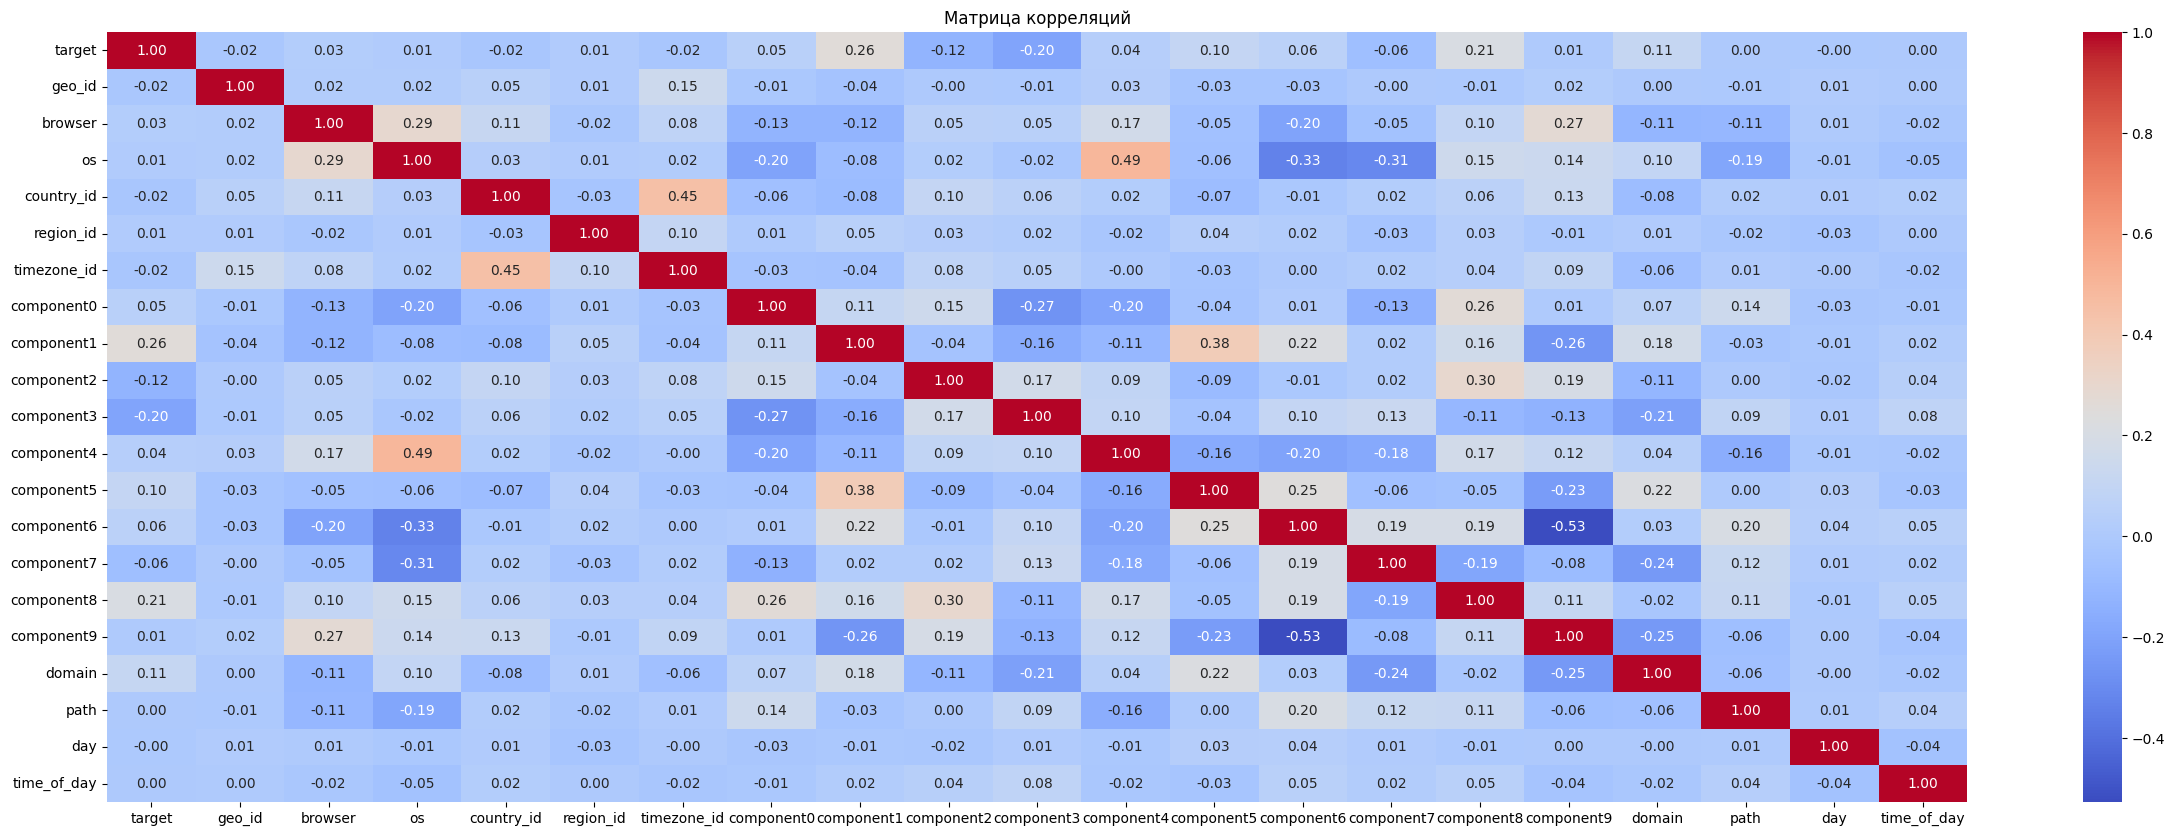

In [140]:

# 1. Матрица корреляций
corr_matrix = df.corr()

# 2. Построение тепловой карты
plt.figure(figsize=(30, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций')
plt.show()

In [139]:
#df.drop('second', axis=1, inplace=True)

bins   = [-1, 5, 12, 17, 21, 24]
labels = ['night', 'morning', 'afternoon', 'evening', 'late']
#df['time_of_day'] = pd.cut(df['hour'], bins=bins, labels=labels, right=False, include_lowest=True).astype('string')
#df.drop('hour', axis=1, inplace=True)
df_exp['time_of_day'] = le.fit_transform(df_exp['time_of_day']).astype(float)
df

,target,geo_id,browser,os,country_id,region_id,timezone_id,component0,component1,component2,...,component4,component5,component6,component7,component8,component9,domain,path,day,time_of_day
0,0,4799,7.0,0.0,103.0,116.0,205.0,11731,4045,22213,...,-8992,9381,-3496,-3120,-899,16817,3142.0,0.0,26,0.0
1,0,8257,7.0,0.0,103.0,111.0,179.0,11731,4045,22213,...,-8992,9381,-3496,-3120,-899,16817,3142.0,0.0,26,3.0
2,0,3150,56.0,0.0,103.0,160.0,96.0,12498,2451,10304,...,11608,3106,-2188,10573,3347,21870,2874.0,46696.0,26,0.0
3,0,2740,7.0,0.0,103.0,99.0,179.0,11731,4045,22213,...,-8992,9381,-3496,-3120,-899,16817,3142.0,0.0,26,3.0
4,0,4863,56.0,0.0,103.0,200.0,22.0,11731,4045,22213,...,-8992,9381,-3496,-3120,-899,16817,3142.0,0.0,26,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601285,1,3663,56.0,0.0,103.0,239.0,179.0,18174,17591,3257,...,8043,13263,2312,1791,9121,5170,697.0,0.0,26,0.0
601286,0,2628,6.0,10.0,103.0,134.0,179.0,14961,13188,3978,...,13751,14055,1141,-10698,7083,9270,2120.0,0.0,25,2.0
601287,0,1198,7.0,0.0,103.0,81.0,22.0,12332,17481,12664,...,5146,11562,4316,15017,1423,-981,805.0,24188.0,26,3.0
601288,0,2521,7.0,0.0,103.0,252.0,179.0,13459,-6413,13160,...,5498,3875,13246,10259,-1630,-14647,214.0,34498.0,26,3.0


# Обучение модели

In [122]:
# Разделение основной таблицы на тренировочную и тестовую выборку по признаку 'test' и запоминание user_id
test = df_comb[df_comb['test'] == 1].drop(['test', 'target'], axis = 1)
users_test = test['user_id']
print('users_test:', users_test.shape)
test = test.drop('user_id', axis = 1)
train = df_comb[df_comb['test'] == 0].drop(['test','user_id'], axis = 1)

users_test: (153083,)


In [123]:

y = train['target']
X = train.drop(['target'], axis = 1)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# выделение строчных признаков
cat_features = ['domain', 'path', 'country_id', 'timezone_id', 'browser', 'os','region_id', 'time_of_day']
# Инициализация модели
model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=10,
    eval_metric='Accuracy',
    verbose=80,
    random_seed=81,
    cat_features = cat_features
)

# Обучение
model.fit(X_train, y_train)

# Предсказание
y_pred = model.predict(X_test)

# Оценка качества
print("Accuracy:", accuracy_score(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

0:	learn: 0.7956810	total: 278ms	remaining: 9m 14s
80:	learn: 0.8314582	total: 21.2s	remaining: 8m 21s
160:	learn: 0.8396489	total: 48.8s	remaining: 9m 17s
240:	learn: 0.8429522	total: 1m 18s	remaining: 9m 30s
320:	learn: 0.8458086	total: 1m 46s	remaining: 9m 19s
400:	learn: 0.8479415	total: 2m 17s	remaining: 9m 6s
480:	learn: 0.8497896	total: 2m 47s	remaining: 8m 48s
560:	learn: 0.8514444	total: 3m 16s	remaining: 8m 24s
640:	learn: 0.8528934	total: 3m 47s	remaining: 8m 2s
720:	learn: 0.8541261	total: 4m 17s	remaining: 7m 36s
800:	learn: 0.8552487	total: 4m 56s	remaining: 7m 23s
880:	learn: 0.8561697	total: 5m 37s	remaining: 7m 8s
960:	learn: 0.8571155	total: 6m 18s	remaining: 6m 49s
1040:	learn: 0.8580115	total: 6m 58s	remaining: 6m 25s
1120:	learn: 0.8590447	total: 7m 40s	remaining: 6m
1200:	learn: 0.8599137	total: 8m 21s	remaining: 5m 33s
1280:	learn: 0.8606267	total: 9m 3s	remaining: 5m 5s
1360:	learn: 0.8613502	total: 9m 44s	remaining: 4m 34s
1440:	learn: 0.8620840	total: 10m 25s	

In [ ]:
# сохранение модели
import joblib
joblib.dump(model, 'mdl_catboost.joblib')

['mdl_catboost.joblib']

In [ ]:
# предсказания для test выборки
preds = model.predict_proba(test)
# формирование датафрейма submission, где два столбца - user_id, target; где target - вероятность того что пользователь имеет пол 1
submission = pd.DataFrame(users_test)
submission['predictions'] = preds[:,1]
submission = submission.drop_duplicates(subset=['user_id'])
submission= pd.merge(test_users, submission, how = 'left', on = 'user_id')
#print(submission.isna().sum())
#display(submission)
# сохранение итогов предсказания в csv файл
submission.to_csv('submission.csv', index=False)